# Scikit-RF Circuit model of the WEST ICRH Antenna 

In this notebook, we model a WEST ICRH antenna using the [`scikit-rf` Python package](https://scikit-rf.readthedocs.io). 

In [1]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
# usual imports
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm  # nice progress bar

In [3]:
# import scikit-rf and tune the figure style
import skrf as rf
rf.stylely(style_file='skrf2.mplstyle')

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


## Conjugate-T and Resonant Loop Circuits

First, we import the few elements of the antenna circuit: RF feedthrough, impedance transformer and bridge.

In [4]:
# antenna elements
bridge = rf.Network('S_Matrices/Antenna/WEST_ICRH_bridge.s3p', f_unit='MHz')
impedance_transformer = rf.Network('S_Matrices/Antenna/WEST_ICRH_impedance-transformer.s2p', f_unit='MHz')
window = rf.Network('S_Matrices/Antenna/WEST_ICRH_window.s2p', f_unit='MHz')

#bridge = rf.Network('S_Matrices/Antenna/WEST_ICRH_final_WEST-final-bridge.s3p', f_unit='MHz')
#impedance_transformer = rf.Network('S_Matrices/Antenna/WEST_ICRH_final_WEST-final-impedance-transformer.s2p', f_unit='MHz')
#window = rf.Network('S_Matrices/Antenna/WEST_ICRH_final_WEST-final-window.s2p', f_unit='MHz')

#bridge = rf.Network('S_Matrices/Antenna/Bridge_Walid.s3p', f_unit='MHz')
#impedance_transformer_window = rf.Network('S_Matrices/Antenna/ImpTransf_Window_Walid.s2p', f_unit='MHz')
#stub = rf.Network('S_Matrices/Antenna/Stub_Walid.s3p', f_unit='MHz')

# frequency band is the same that the networks's
frequency = window.frequency
# additional elements which will be usefull later
port1 = rf.Circuit.Port(frequency, 'port1', z0=window.z0[:,0])
ground_upper = rf.Circuit.Ground(frequency, name='gnd_upper', z0=bridge.z0[:,1])
ground_lower = rf.Circuit.Ground(frequency, name='gnd_lower', z0=bridge.z0[:,2])

The matching capacitors are modeled below using an equivalent lumped circuit. Details concerning this model are given in [a dedicated notebook](WEST%20ICRH%20Antenna%20Capacitors.ipynb). Another possibility could have been to interpolate between full-wave simulated capacitor networks, calculated for various capacitance values using a `NetworkSet`. 

In [5]:
def capa(C, freq, z0=50, R=1e-2, L=29.9, R1=1e-2, C1=25.7, L1=2.4):
    '''
    Equivalent lumped model of the WEST ICRH antenna capacitor.
    
    R are given in Ohm, C in pF and L in nH
    ''' 
    line = rf.media.DefinedGammaZ0(frequency=freq, z0=z0)
    
    pre = line.resistor(R1) ** line.inductor(L1*1e-9) ** line.shunt_capacitor(C1*1e-12)
    post= line.shunt_capacitor(C1*1e-12) ** line.resistor(R1) ** line.inductor(L1*1e-9)
    cap = line.resistor(R) ** line.inductor(L*1e-9) ** line.capacitor(C*1e-12)
    
    return pre ** cap ** post 

In `scikit-rf`, there is two ways of building circuit made of various networks. The first method consists in connecting networks one by one using `Network` methods such as `connect`. The second method consists in defining all the connections between networks once, then use the `Circuit` object to build the resultant network. While the later method can be more verbose than the former, it has some advantages when the circuit has many connections. 

Moreover, the later way allows one to obtain the s-parameters also inside the circuit (at each connections) which can be usefull to deduce voltage/current inside the circuit.

In [6]:
# below we define the load impedance for a Resonance Loop antenna.
# Depending of the circuit building approach, the load are either 
# a single or a 2-port networks. 
def load_network(Zload, z0):
    ' 1-port circuit '
    zs = np.full((len(port1.f),1,1), Zload)
    return rf.Network.from_z(zs, frequency=frequency, z0=z0)
    
def load_network_circuit(Zload, z0, name='load'):
    ' 2-ports circuit, since grounding is a specific network'
    line = rf.media.DefinedGammaZ0(frequency=frequency, z0=z0)
    return line.resistor(Zload, name=name, z0=z0)

In [7]:
def half_antenna_network(Cs, Zload=1+30j):
    C_upper, C_lower = Cs
    # creates the circuit=window + impedance transformer + bridge
    # impedance_transformer : port0 40 Ohm ; port1 5 Ohm 
    # window                : port0 30 ohm ; port1 40 Ohm 
    #    1-imp_tr-0 -- 1-window-0 ==> 1:5 Ohm -- 0:30 Ohm
    window_imptrans = rf.connect(window, 1, impedance_transformer, 0)

    # bridge port0: input
    window_imptrans_bridge = rf.connect(window_imptrans, 1, bridge, 0) 

    capa_upper = capa(C_upper, frequency, z0=50) 
    capa_lower = capa(C_lower, frequency, z0=50)
    
    load_upper = load_network(Zload, z0=50)
    load_lower = load_network(Zload, z0=50)
    
    CT = rf.connect(rf.connect(window_imptrans_bridge,1, capa_upper,0),2, capa_lower,0)

    ntw = rf.connect(rf.connect(CT, 1, load_upper, 0),1, load_lower, 0)
    return ntw  

def half_antenna_circuit(Cs, Zload=1+30j):
    C_upper, C_lower = Cs
    capa_upper = capa(C_upper, frequency, z0=bridge.z0[0][1]) 
    capa_upper.name = 'capa_upper'
    capa_lower = capa(C_lower, frequency, z0=bridge.z0[0][2])
    capa_lower.name = 'capa_lower'
    
    load_upper = load_network_circuit(Zload, z0=bridge.z0[0][1], name='load_upper', )
    load_lower = load_network_circuit(Zload, z0=bridge.z0[0][2], name='load_lower', )
    
    connections = [
        [(port1, 0), (window, 0)],
        [(window, 1), (impedance_transformer, 0)],
        [(impedance_transformer, 1), (bridge, 0)],
        [(bridge, 1), (capa_upper, 0)],
        [(bridge, 2), (capa_lower, 0)],
        [(capa_upper, 1), (load_upper, 0)],
        [(capa_lower, 1), (load_lower, 0)],
        [(load_upper, 1), (ground_upper, 0)],
        [(load_lower, 1), (ground_lower, 0)]
    ]
    
    return rf.Circuit(connections)

An other advantage of the `Circuit` approach, is that it allows visualizing the circuit graph. This is useful to verify that the circuit is the one that we want (it can also display each network port numbers and characteristic impedances).  

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


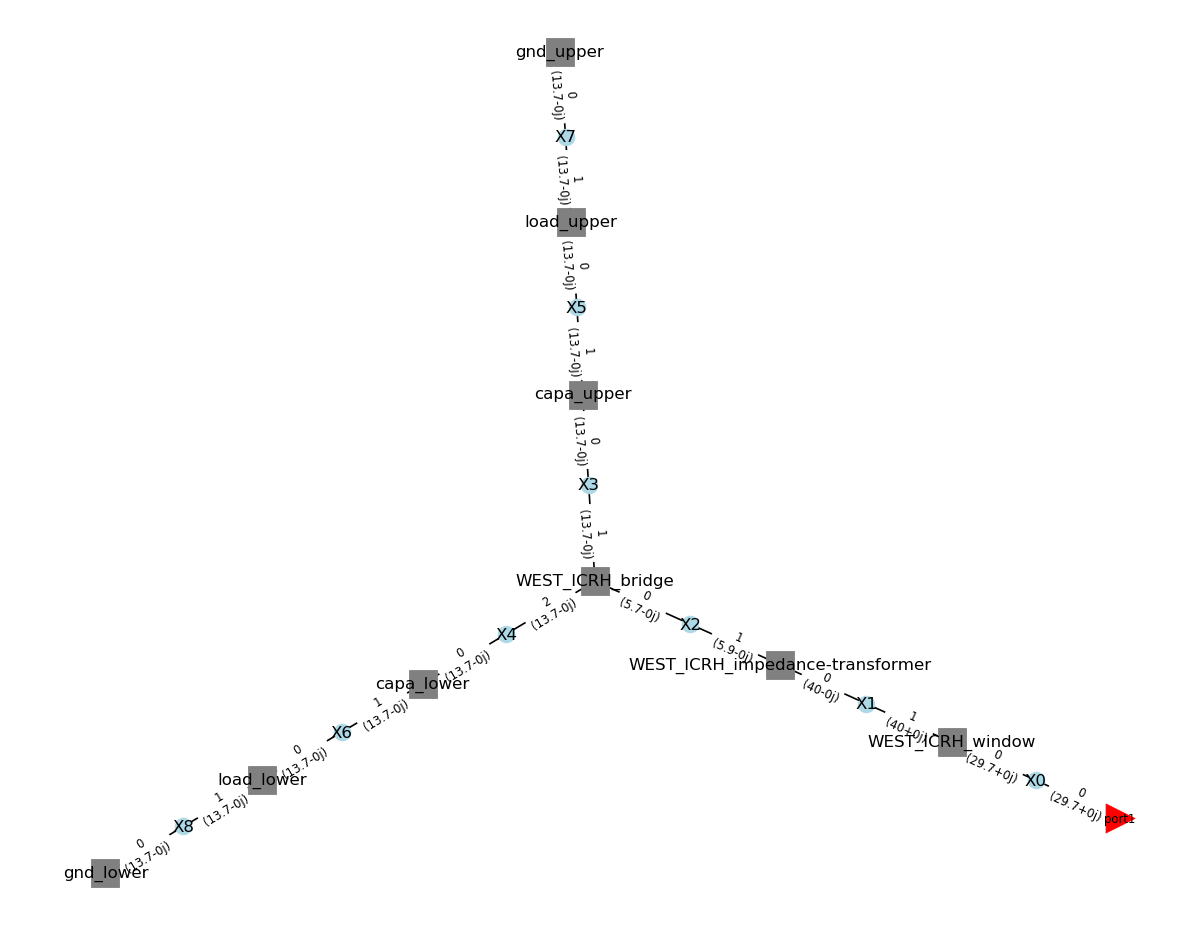

In [8]:
options = {
    'network_labels': True,
    'edge_labels': True, 
    'port_labels': True,
    'network_fontsize': 10,
    'inter_size': 100,
    'edge_fontsize': 7,
    'inter_labels': True
}
half_antenna_circuit([50,50], Zload=1+30j).plot_graph(**options)
plt.gcf().savefig('RL_graph.png', dpi=150)

## Matching the Resonant Loop

Now that the network model has been built, let's find for which capacitance values the resonant loop is matched to port1 (that is, when $Z_{11}=Z_0$)

In [9]:
def optim_fun_RL(C, f_match=55e6, z_load=1+30j, z_match=30-0j):
    '''
    Returns the residuals of Z - Z_match
    '''
    # # from Network ('classic way')
    # ntw = half_antenna_network(C, Zload=z_load)
    # # from Circuit
    ntw = half_antenna_circuit(C, Zload=z_load).network
    
    index_f_match = np.argmin(np.abs(ntw.f - f_match))

    Z11_re = ntw.z_re[index_f_match,0,0].squeeze()
    Z11_im = ntw.z_im[index_f_match,0,0].squeeze()
    r = np.array([  # residuals for both real and imaginary parts
        (Z11_re - np.real(z_match)), 
        (Z11_im - np.imag(z_match))
    ])
    r = (Z11_re - np.real(z_match))**2 + (Z11_im - np.imag(z_match))**2
    return r

In [10]:
f_match = 50e6
z_load = 1 + 30j
z_match = 30 - 0j

# try finding a solution until it's a physical one.
success = False
while success == False:
    # generate a random C sets, centered on 70 +/- 40
    C0 = 70 + (-1 + 2*scipy.random.rand(2))*40

    sol = scipy.optimize.minimize(optim_fun_RL, C0, 
                                  args=(f_match, z_load, z_match),
                                  bounds=((12,200), (12,200))
                                 )
    # test if the solution found is the capacitor range
    success = sol.success
    if np.isclose(sol.x, 150).any() or \
        np.isclose(sol.x, 12).any() or \
        np.isclose(sol.x[0], sol.x[1]):
        success = False
        print('Wrong solution (out of range capacitor) ! Re-doing...')
       
    print(success, sol.x)

True [56.44320516 64.91846689]


Let's compare antenna's response versus frequency, with both circuit building approaches:

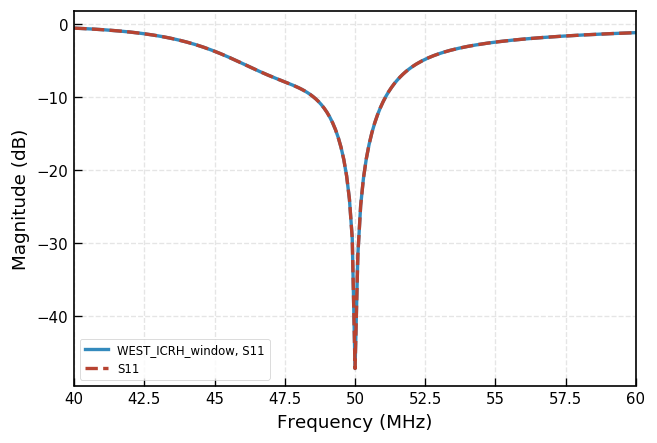

In [11]:
half_antenna_network(sol.x).plot_s_db(m=0, n=0, lw=2)
half_antenna_circuit(sol.x).network.plot_s_db(m=0, n=0, ls='--', lw=2)

## Capacitor capacitances range

There is two set of capacitance solutions $(C_{top}, C_{bot})$ at a given frequency, distinct by either $C_{top}>C_{bot}$ (solution#1) or the $C_{top}<C_{bot}$ (solution#2). Below we slightly improve the research of matching solutions, using a constraint optimization to get either one or the second solution.

In [12]:
def find_match(f_match=55e6, z_load=1+30j, z_match=30-0j, solution_number=1):
    """
    Return the match condition C=[Cupper,Clower] 
    for a specified loading, matching and solution conditions.
    
    solution_number = 1 --> C_top > C_lower
    solution_number = 2 --> C_top < C_lower
    """
    # setup constraint optimization to force finding the requested solution
    sol_sign = +1 if solution_number == 1 else -1
    A = np.array([[1, 0], [0, 1], [sol_sign*-1, sol_sign*1]])
    lb = np.array([12, 12, -np.inf])
    ub = np.array([150, 150, 0])
    const = scipy.optimize.LinearConstraint(A, lb, ub)

    # try finding a solution until it's a physical one.
    success = False
    while success == False:
        # generate a random C sets, centered on 70 +/- 40
        # satisfying the solution condition
        contin = True
        while contin:
            C0 = 70 + (-1 + 2*scipy.random.rand(2))*40
            if C0[0] > C0[1] and solution_number == 1:
                contin = False
            elif C0[0] < C0[1] and solution_number == 2:
                contin = False

        sol = scipy.optimize.minimize(optim_fun_RL, C0, 
                                      args=(f_match, z_load, z_match),
                                      constraints=const
                                     )
        # test if the solution found is the capacitor range
        success = sol.success
        if np.isclose(sol.x, 150).any() or \
            np.isclose(sol.x, 12).any() or \
            np.isclose(sol.x[0], sol.x[1]):
            success = False
            print('Wrong solution (out of range capacitor) ! Re-doing...')

        print(success, f'solution #{solution_number}:', sol.x)
        
    return sol.x

### Matching point vs Loading Resistance

In [13]:
freqs = 50e6  # Hz

Cs_sol2 = []

z_load = np.arange(0.2, 2, step=.1) + 30j
z_match = 30 - 0j

for z_l in tqdm(z_load):
    Cs_sol2.append(find_match(f_match=freqs, solution_number=1, 
                   z_load=z_l, z_match=z_match))

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [56.94512725 12.        ]
True solution #1: [62.00058779 57.84683293]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [62.4805796 57.5155475]
True solution #1: [62.89760249 57.25469838]
True solution #1: [63.27485928 57.04253077]
True solution #1: [63.62554611 56.86762834]
True solution #1: [63.95858488 56.7232759 ]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [57.93867849 12.        ]
True solution #1: [64.28098495 56.60517539]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [64.5988557 56.5107958]
True solution #1: [64.91835294 56.4384797 ]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [55.4598849 55.4598849]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [58.33508595 12.        ]
Wrong solution (out of range capacitor) ! Re

In [37]:
z_load = np.arange(0.2, 2, step=.1) + 30j

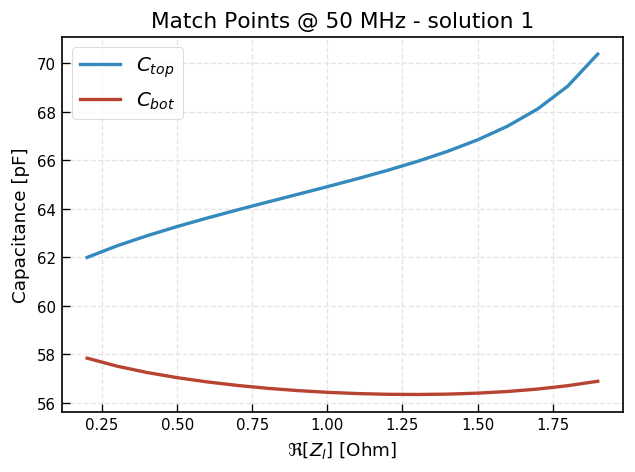

In [45]:
fig, ax = plt.subplots()
ax.plot(np.real(z_load), Cs_sol2, lw=2)
ax.legend(('$C_{top}$', '$C_{bot}$'), fontsize=12)
ax.set_xlabel(r'$\Re\left[ Z_l \right]$ [Ohm]')
ax.set_ylabel('Capacitance [pF]')
ax.set_title('Match Points @ 50 MHz - solution 1')
fig.savefig('MatchPoints50MHz.png', dpi=150)

### Matching Point vs frequency

In [14]:
freqs = np.arange(start=40e6, stop=60e6, step=5e6)  # Hz

Cs_sol1 = []

z_load = 1 + 30j
z_match = 30 - 0j

for f in tqdm(freqs):
    Cs_sol1.append(find_match(f_match=f, solution_number=2, 
                   z_load=z_load, z_match=z_match))

True solution #2: [79.18706327 87.28014894]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #2: [12.         79.95258798]
True solution #2: [76.60944216 84.90498794]
True solution #2: [74.02246302 82.56075408]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #2: [12.         74.20794057]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #2: [12.         74.20799495]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #2: [12.         74.20798446]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #2: [12.         74.20799821]
True solution #2: [71.48795788 80.22904138]
True solution #2: [69.03697017 77.91261999]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #2: [12.         69.05916322]
True solution #2: [66.68364849 75.62199535]
True solution #2: [64.43335129 73.36924608]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #2: [12.         64.41130875]

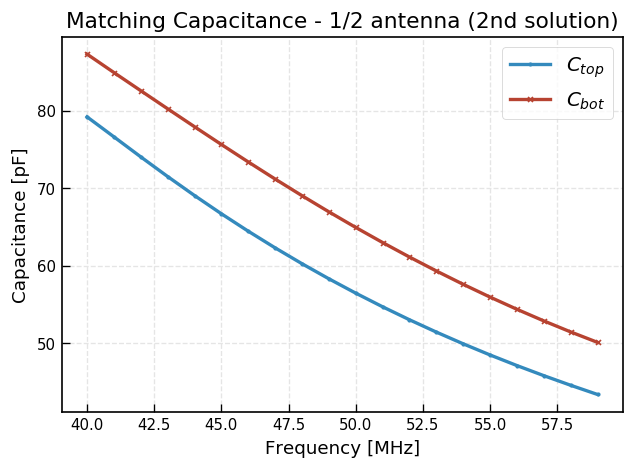

In [49]:
Cs_sol1 = np.array(Cs_sol1)
fig, ax = plt.subplots()
ax.plot(freqs/1e6, Cs_sol1[:,0], marker='.', label='$C_{top}$', lw=2)
ax.plot(freqs/1e6, Cs_sol1[:,1], marker='x', label='$C_{bot}$', lw=2)
ax.legend(fontsize=12)
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Capacitance [pF]')
ax.set_title('Matching Capacitance - 1/2 antenna (2nd solution)')
fig.savefig('MatchPoints_vs_freq.png', dpi=150)

## Capacitor Current and Voltages

As the s-parameters of all intersections are accessible from the antenna `Circuit`, it is possible to determine voltages and currents at each points of the circuit. 

In [16]:
Z_load = 1 + 30j
P_in = 1e6  # W
f_match=55e6

Cs = find_match(f_match=f_match, z_load=Z_load)

half_antenna = half_antenna_circuit(Cs, Zload=Z_load)

True solution #1: [55.93257174 48.46212457]


The complete circuit s-parameters $\mathbf{S}$ is of shape $(2 N_c, 2 N_c)$, where $N_c$ is the number of connections (times 2 because of forward and backward waves for each connection). As the input port corresponds to the intersection #0, the excitation vector $\bf{a}$, of size $2 N_c$ will thus be:
$$
\bf{a}
=
\left(
\begin{array}{c} 
\sqrt{2 P_{in}} \\
0 \\
\vdots \\
0
\end{array}
\right)
$$

In [17]:
a = np.zeros(half_antenna.connections_nb*2)  # shape (nfreqs, nbwaves)
a[0] = np.sqrt(2*P_in)

The output waves at each connection $\bf{b}$ is deduced from:
$$
\bf{b} = \mathbf{S} \bf{a}
$$

In [18]:
# calculation is made for all the frequencies of the circuit
b = half_antenna.s @ a  # shape (nfreqs, nbwaves)

Looking into the circuit connection list (or to the graph figure), the connections between the capacitors and the loads correspond to connections (#10,#11) and (#12,#13) for upper and lower respectively:

In [19]:
half_antenna.connections_list[10]

[10,
 (2-Port Network: 'capa_upper',  40.0-60.0 MHz, 201 pts, z0=[13.68468209-0.00334742j 13.68468209-0.00334742j],
  1)]

In [20]:
half_antenna.connections_list[11]

[11,
 (2-Port Network: 'load_upper',  40.0-60.0 MHz, 201 pts, z0=[13.68468209-0.00334742j 13.68468209-0.00334742j],
  0)]

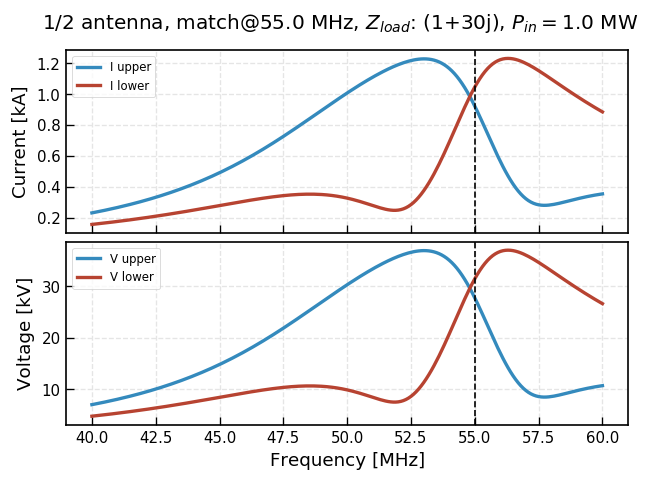

In [21]:
z0 = 13.7
I_upper = (b[:,11] - b[:,10])/np.sqrt(z0)
V_upper = (b[:,11] + b[:,10])*np.sqrt(z0)
I_lower = (b[:,13] - b[:,12])/np.sqrt(z0)
V_lower = (b[:,13] + b[:,12])*np.sqrt(z0)

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(half_antenna.frequency.f/1e6, np.abs(I_upper)/1e3, label='I upper', lw=2)
ax1.plot(half_antenna.frequency.f/1e6, np.abs(I_lower)/1e3, label='I lower', lw=2)
ax2.plot(half_antenna.frequency.f/1e6, np.abs(V_upper)/1e3, label='V upper', lw=2)
ax2.plot(half_antenna.frequency.f/1e6, np.abs(V_lower)/1e3, label='V lower', lw=2)
[ax.legend() for ax in (ax1, ax2)]
ax2.set_xlabel('Frequency [MHz]')
[ax.axvline(f_match/1e6, ls='--', c='k') for ax in (ax1, ax2)]
ax1.set_ylabel('Current [kA]')
ax2.set_ylabel('Voltage [kV]')
plt.subplots_adjust(hspace=0.05)
plt.suptitle(f'1/2 antenna, match@{f_match/1e6} MHz, $Z_{{load}}$: {Z_load}, $P_{{in}}={P_in/1e6}$ MW')
fig.savefig('half_antenna_current_voltage.png', dpi=150)

The Voltages and currents at the match frequency are:

In [22]:
idx_f = np.argmin(np.abs(half_antenna.frequency.f - f_match))

print('Upper Current (mag, kA):', np.abs(I_upper[idx_f])/1e3)
print('Lower Current (mag, kA):', np.abs(I_lower[idx_f])/1e3)

print('Upper Voltage (mag, kV):', np.abs(V_upper[idx_f])/1e3)
print('Lower Voltage (mag, kV):', np.abs(V_lower[idx_f])/1e3)

Upper Current (mag, kA): 0.9230998457310687
Lower Current (mag, kA): 1.0469217648046718
Upper Voltage (mag, kV): 27.73939055124126
Lower Voltage (mag, kV): 31.456151455666674


## Load resilience

To demonstrate the load resilience of the antenna, first the antenna is matched for a given load:

In [23]:
Z_load = 0.5 + 30j
f_match = 55e6

Cs = find_match(f_match=f_match, z_load=Z_load)

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [54.6684476  49.10567408]


Then the VSWR of the antenna is calculated for a load sweep

In [24]:
R_loads = np.arange(start=.1, stop=3, step=.05) + 30j

idx_f = np.argmin(np.abs(frequency.f - f_match))
VSWRs = [half_antenna_circuit(Cs, Zload=Z).network[idx_f].s_vswr \
         for Z in R_loads]

Text(0, 0.5, 'VSWR')

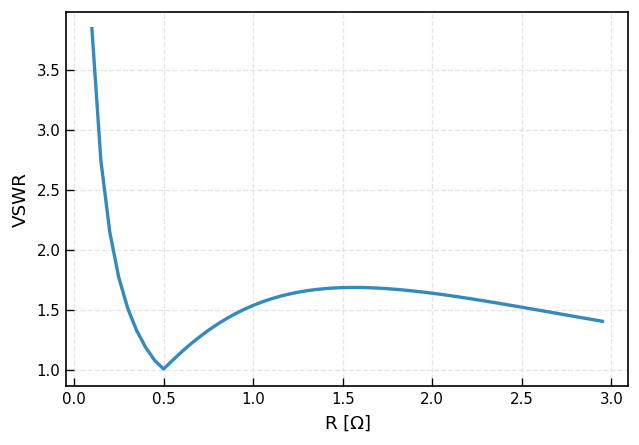

In [25]:
fig, ax = plt.subplots()
ax.plot(np.real(R_loads), np.array(VSWRs).squeeze(), lw=2)
ax.set_xlabel('R [$\Omega$]')
ax.set_ylabel('VSWR')

## Full-antenna: Resonant Double Loop

The full antenna consist in two resonant loop side by side. The radiation to the plasma (or vacuum) is modeled from the TOPICA code or from HFSS.  

In [26]:
left_bridge = rf.Network('S_Matrices/Antenna/WEST_ICRH_bridge.s3p', f_unit='MHz', name='left_bridge').interpolate(frequency)
left_impedance_transformer = rf.Network('S_Matrices/Antenna/WEST_ICRH_impedance-transformer.s2p', f_unit='MHz', name='left_impedance_transformer').interpolate(frequency)
left_window = rf.Network('S_Matrices/Antenna/WEST_ICRH_window.s2p', f_unit='MHz', name='left_window').interpolate(frequency)

right_bridge = rf.Network('S_Matrices/Antenna/WEST_ICRH_bridge.s3p', f_unit='MHz', name='right_bridge').interpolate(frequency)
right_impedance_transformer = rf.Network('S_Matrices/Antenna/WEST_ICRH_impedance-transformer.s2p', f_unit='MHz', name='right_impedance_transformer').interpolate(frequency)
right_window = rf.Network('S_Matrices/Antenna/WEST_ICRH_window.s2p', f_unit='MHz', name='right_window').interpolate(frequency)

left_port = rf.Circuit.Port(frequency, 'left_port', z0=left_window.z0[:,0])
right_port = rf.Circuit.Port(frequency, 'right_port', z0=right_window.z0[:,0])

frequency = right_window.frequency
# Load a plasma response (from TOPICA)
front_face = rf.Network('S_Matrices/Plasma/TOPICA/S_TSproto12_55MHz_Profile1.s4p', name='FrontFace')
# for compatibility with skrf, copy the Frequency object from Bridge
# and duplicate the S-parameters and z0 idenditically for all the frequencies
front_face.frequency = frequency
front_face.s = np.tile(front_face.s, (len(frequency), 1, 1))
# # Load a vacuum response (from HFSS)
# front_face = rf.Network('S_Matrices/Plasma/HFSS/WEST_ICRH_FrontFace_vacuum.s4p').interpolate(frequency)

In [27]:
def antenna_circuit(Cs):
    '''
    Returns the full antenna circuit for a given set of capacitances
    '''
    C_left_upper, C_left_lower, C_right_upper, C_right_lower = Cs
    capa_left_upper = capa(C_left_upper, frequency, z0=bridge.z0[0][1]) 
    capa_left_upper.name = 'capa_left_upper'
    capa_left_lower = capa(C_left_lower, frequency, z0=bridge.z0[0][2])
    capa_left_lower.name = 'capa_left_lower'
    capa_right_upper = capa(C_right_upper, frequency, z0=bridge.z0[0][1]) 
    capa_right_upper.name = 'capa_right_upper'
    capa_right_lower = capa(C_right_lower, frequency, z0=bridge.z0[0][2])
    capa_right_lower.name = 'capa_right_lower'    
   
    connections = [
        # left conjugate T
        [(left_port, 0), (left_window, 0)],
        [(left_window, 1), (left_impedance_transformer, 0)],
        [(left_impedance_transformer, 1), (left_bridge, 0)],
        [(left_bridge, 1), (capa_left_upper, 0)],
        [(left_bridge, 2), (capa_left_lower, 0)],
        # right conjugate T
        [(right_port, 0), (right_window, 0)],
        [(right_window, 1), (right_impedance_transformer, 0)],
        [(right_impedance_transformer, 1), (right_bridge, 0)],
        [(right_bridge, 1), (capa_right_upper, 0)],
        [(right_bridge, 2), (capa_right_lower, 0)],
        # front face
        [(capa_left_upper, 1), (front_face, 0)],
        [(capa_left_lower, 1), (front_face, 2)],
        [(capa_right_upper, 1), (front_face, 1)],
        [(capa_right_lower, 1), (front_face, 3)],
    ]
    
    return rf.Circuit(connections)

The antenna circuit's graph looks like:

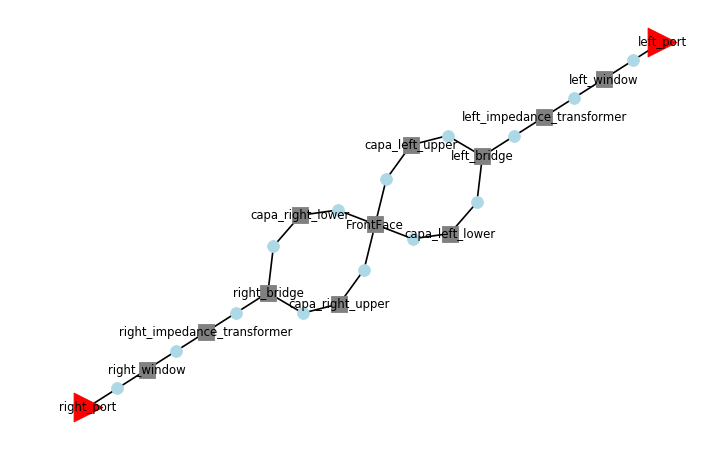

In [28]:
fig, ax = plt.subplots()
rf.plotting.plot_circuit_graph(antenna_circuit([50,50,50,50]),ax=ax, 
                                          edge_labels=False, 
                                          network_labels=True,
                                         inter_size=50,
                                         network_fontsize=7,
                                         network_size=100,
                                         port_labels=True)
fig.savefig('antenna_graph.png', dpi=150)


Below we define the optimization functions and matching point determination. All the four capacitors are matched by minimizing the active impedance of each ports with respect to the matching impedance `z_match`

In [29]:
def optim_fun_antenna(C, f_match=55e6, z_load=1+30j, z_match=30-0j):
    '''
    Optimization function. Returns the residuals of Z(active) - Z_match
    '''
    ntw = antenna_circuit(C).network
    S = ntw.s
    
    index_f_match = np.argmin(np.abs(ntw.f - f_match))
    
    # active s-parameters
    S1_active = (S[:,0,0]*1 + S[:,0,1]*-1)/(1)
    S2_active = (S[:,1,0]*1 + S[:,1,1]*-1)/(-1)    
    # active impedance parameters
    Z1_active = ntw.z0[:,0]*(1 + S1_active)/(1 - S1_active)
    Z2_active = ntw.z0[:,1]*(1 + S2_active)/(1 - S2_active)

    r = np.array([  # residuals for both real and imaginary parts
        (np.real(Z1_active[index_f_match]) - np.real(z_match))**2, 
        (np.imag(Z1_active[index_f_match]) - np.imag(z_match))**2,
        (np.real(Z2_active[index_f_match]) - np.real(z_match))**2, 
        (np.imag(Z2_active[index_f_match]) - np.imag(z_match))**2,     
    ])
    return r

In [30]:
def find_match(f_match=55e6, z_match=30-0j):
    """
    Return the match condition:
    C = [C_left_upper, C_left_lower, C_right_upper, C_right_lower]
    """
    # try finding a solution until it's a physical one.
    success = False
    while success == False:
        C0 = 70 + (-1 + 2*scipy.random.rand(4))*40

        sol = scipy.optimize.least_squares(optim_fun_antenna, C0, 
                                  args=(f_match, z_load, z_match),
                                bounds=(12,150),
                                     )
        # test if the solution found is the capacitor range
        success = sol.success
        if np.any(sol.x >= 150) or np.any(sol.x <= 12) or \
            np.isclose(sol.x, 12).any() or np.isclose(sol.x, 150).any():
            success = False
            print('Wrong solution (out of range capacitor) ! Re-doing...')

        print(success, sol.x)
        
    return sol.x

In [31]:
C = find_match()

True [46.78969355 53.69649083 53.69314189 46.80131801]


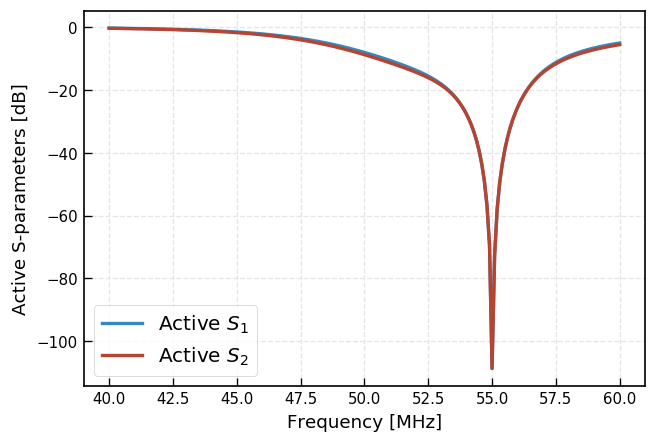

In [32]:
antenna_matched = antenna_circuit(C)

# exciting in dipole
s_act = antenna_matched.s_active([1, -1])

fig, ax = plt.subplots()
ax.plot(antenna_matched.frequency.f/1e6, 20*np.log(np.abs(s_act)), lw=2)
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Active S-parameters [dB]')
ax.legend(('Active $S_{1}$', 'Active $S_{2}$'), fontsize=12)
fig.savefig('activeS_vs_freq.png', dpi=150)

## Interactive Antenna Tuning
Just for fun below, the $S_{11}$ and $S_{22}$ of the full antenna is illustrated for a set of capacitances that can be tuned interactively. 

In [33]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [34]:
@interact(C1=(15,120.0,0.01), C2=(15,120.0,0.01), 
         C3=(15,120.0,0.01), C4=(15,120.0,0.01), )
def plot_sii(C1, C2, C3, C4):
    C=[C1, C2, C3, C4]
    antenna_circuit(C).network.plot_s_db(m=0, n=0)
    antenna_circuit(C).network.plot_s_db(m=1, n=1)

interactive(children=(FloatSlider(value=67.5, description='C1', max=120.0, min=15.0, step=0.01), FloatSlider(v…

# References

In [35]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """

   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style('custom.css')